In [1]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset.
# implemented Advanced Ensemble XGB Extreme Gradient Boosting.

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder


/tmp/ipykernel_1741311/2672896683.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-26 16:05:31.927207: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 16:05:31.968228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 16:

In [ ]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

# tf.keras.backend.clear_session()

In [2]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

In [3]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# # Convert data to TensorFlow tensors
# X_train_tf = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
# y_train_tf = tf.convert_to_tensor(pd.factorize(y_train)[0], dtype=tf.int64)
# X_test_tf = tf.convert_to_tensor(X_test.values, dtype=tf.float32)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    # XGBoost XGBoost (extreme Gradient Boosting)
    # XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
    # It implements machine learning algo

    xgb_model = xgb.XGBClassifier(
        random_state=42, learning_rate=0.01, objective='multi:softmax')

    # model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
    xgb_model.fit(X_train, y_train)
    xgb_model.score(X_test, y_test)
    y_pred_encoded = xgb_model.predict(X_test)
    

2024-02-26 16:05:48.295575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1046 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-02-26 16:05:48.296177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1047 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

In [5]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    497905
          Malware       1.00      1.00      1.00       114
    Port Scanning       1.00      1.00      1.00    151442

         accuracy                           1.00    649461
        macro avg       1.00      1.00      1.00    649461
     weighted avg       1.00      1.00      1.00    649461



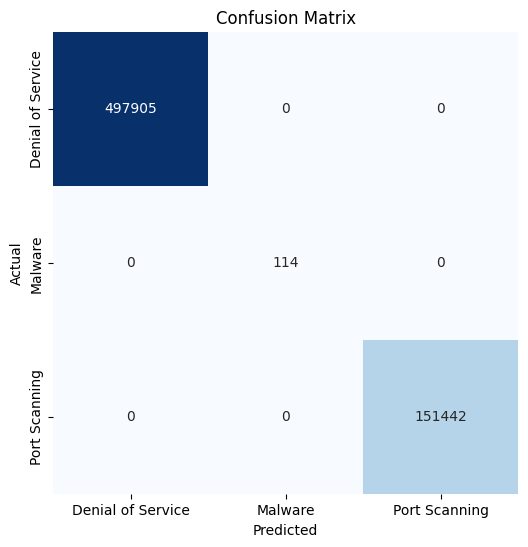

In [6]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1741311/2083536427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


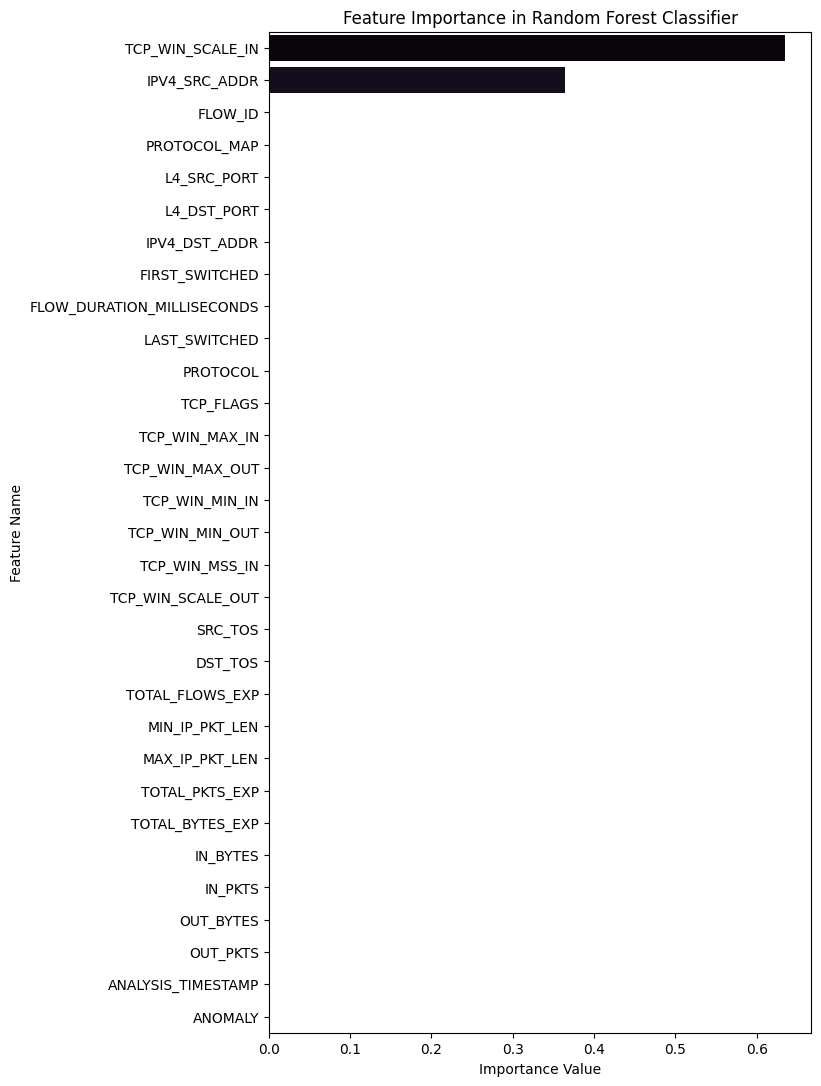

In [7]:
# importances of features in the decision tree model
importance = xgb_model.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 13))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()